<div style="
  background-color:#0F172A;
  border-left:5px solid #3B82F6;
  padding:16px;
  border-radius:10px;
">

## Single-Vector vs. Multi-Vector RAG - Deep Dive

A hands-on guide to understanding **Dense Retrieval** vs. **Late Interaction (ColBERT)**.

**What you'll learn:**
- How Single Vectors struggle with **negation** and **synonyms**
- How Multi-Vectors preserve **token-level** meaning
- Visualizing the **Interaction Matrix** (The "Brain" of models like ColBERT)
- Calculating **MaxSim** scores manually

</div>

## Step 1: Install and Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load a standard lightweight model
model = SentenceTransformer("all-MiniLM-L6-v2")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Create a "Tricky" Knowledge Base

We will use an **Insurance Policy** scenario. This is hard for AI because:
1.  It involves **Exclusions** (Negation).
2.  It uses **Synonyms** ("Water" vs "Liquid").
3.  It has **Distractors** (Same keywords, different context).

In [ ]:
# User asks about water damage
query = "Does the policy cover water damage?"

documents = [
    # Hard Negative (High keyword overlap 'water', 'damage', 'coverage' - but says EXCLUDED)
    "Flood and water damage are strictly EXCLUDED from coverage.",
    
    # True Positive (Semantic match 'liquid spills' = 'water', but no exact keywords)
    "We provide full protection against accidental liquid spills on electronics.",
    
    # Irrelevant Distractor (Has word 'water' but context is wrong)
    "Free water bottles are provided at the gym facility.",
    
    # Irrelevant Distractor (Has word 'damage' but wrong type)
    "Fire damage is covered up to $50,000."
]

print(f"🔎 Query: {query}")
print("-" * 40)
for i, doc in enumerate(documents):
    print(f"Doc {i}: {doc}")

🔎 Query: Does the policy cover water damage?
----------------------------------------
Doc 0: Flood and water damage are strictly EXCLUDED from coverage.
Doc 1: We provide full protection against accidental liquid spills on electronics.
Doc 2: Free water bottles are provided at the gym facility.
Doc 3: Fire damage is covered up to $50,000.


## Step 3: Strategy A - Single Vector (Bi-Encoder)

We compress the entire sentence into **one vector**. 
This often leads to "information loss", the model sees "water" and "damage" in Doc 0 and thinks it's a match, ignoring the word "EXCLUDED". Depending on the model, **Doc 0 (The Exclusion)** often ranks high because it shares the most words with the query. The Single Vector model struggles to "weigh" the word "EXCLUDED" heavily enough against the positive signal of "water damage".

In [ ]:
def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

print("🔢 Encoding documents into Single Vectors...")
# sentence-transformers uses Mean Pooling by default to create one vector per doc
query_vec = model.encode(query)
doc_vecs = model.encode(documents)

print(f"    Query Vector Shape: {query_vec.shape}")
print(f"    Doc Vector Shape:   {doc_vecs[0].shape}")

# Calculate Scores
scores = []
for i, doc_vec in enumerate(doc_vecs):
    score = cosine_sim(query_vec, doc_vec)
    scores.append(score)

# Display Results
df_single = pd.DataFrame({"Document": documents, "Cosine Score": scores})
df_single = df_single.sort_values("Cosine Score", ascending=False)

print("\n📊 SINGLE VECTOR RESULTS:")
display(df_single)

🔢 Encoding documents into Single Vectors...
    Query Vector Shape: (384,)
    Doc Vector Shape:   (384,)

📊 SINGLE VECTOR RESULTS:


,Document,Cosine Score
0,Flood and water damage are strictly EXCLUDED f...,0.552582
3,"Fire damage is covered up to $50,000.",0.422175
1,We provide full protection against accidental ...,0.376862
2,Free water bottles are provided at the gym fac...,0.231203


## Step 4: Strategy B - Multi-Vector (Late Interaction)

Instead of compressing, we extract vectors for **every single token**. 
This allows the model to, for example, compare "water" in the query against "liquid" in the document directly.

In [ ]:
def get_token_embeddings(text):
    # 1. Tokenize and get IDs
    inputs = model.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # 2. Get the actual tokens (including specials like [CLS], [SEP])
    # We use `convert_ids_to_tokens` to ensure we see exactly what the model sees, including special tokens like `[CLS]` (Start) and `[SEP]` (End).
    # This ensures our list of tokens matches the embedding length exactly
    tokens = model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # 3. Run Model to get Embeddings
    with torch.no_grad():
        outputs = model[0].auto_model(**inputs)
    
    # Get embeddings for all tokens
    # Shape: [1, seq_len, 384]
    embeddings = outputs.last_hidden_state[0].numpy() 
    return tokens, embeddings

# Let's inspect Doc 1 (The Liquid Spills doc)
d1_text = documents[1]
tokens, vecs = get_token_embeddings(d1_text)

print(f"📄 Text: {d1_text}")
print(f"🔹 Tokens: {tokens}")
print(f"    Pm Vectors Shape: {vecs.shape} (One vector per token!)")

📄 Text: We provide full protection against accidental liquid spills on electronics.
🔹 Tokens: ['[CLS]', 'we', 'provide', 'full', 'protection', 'against', 'accidental', 'liquid', 'spill', '##s', 'on', 'electronics', '.', '[SEP]']
    Pm Vectors Shape: (14, 384) (One vector per token!)


## Step 5: The Interaction Matrix

We calculate the similarity of **Every Query Token** vs **Every Doc Token**.

🧮 Matrix Shape: (9, 14)


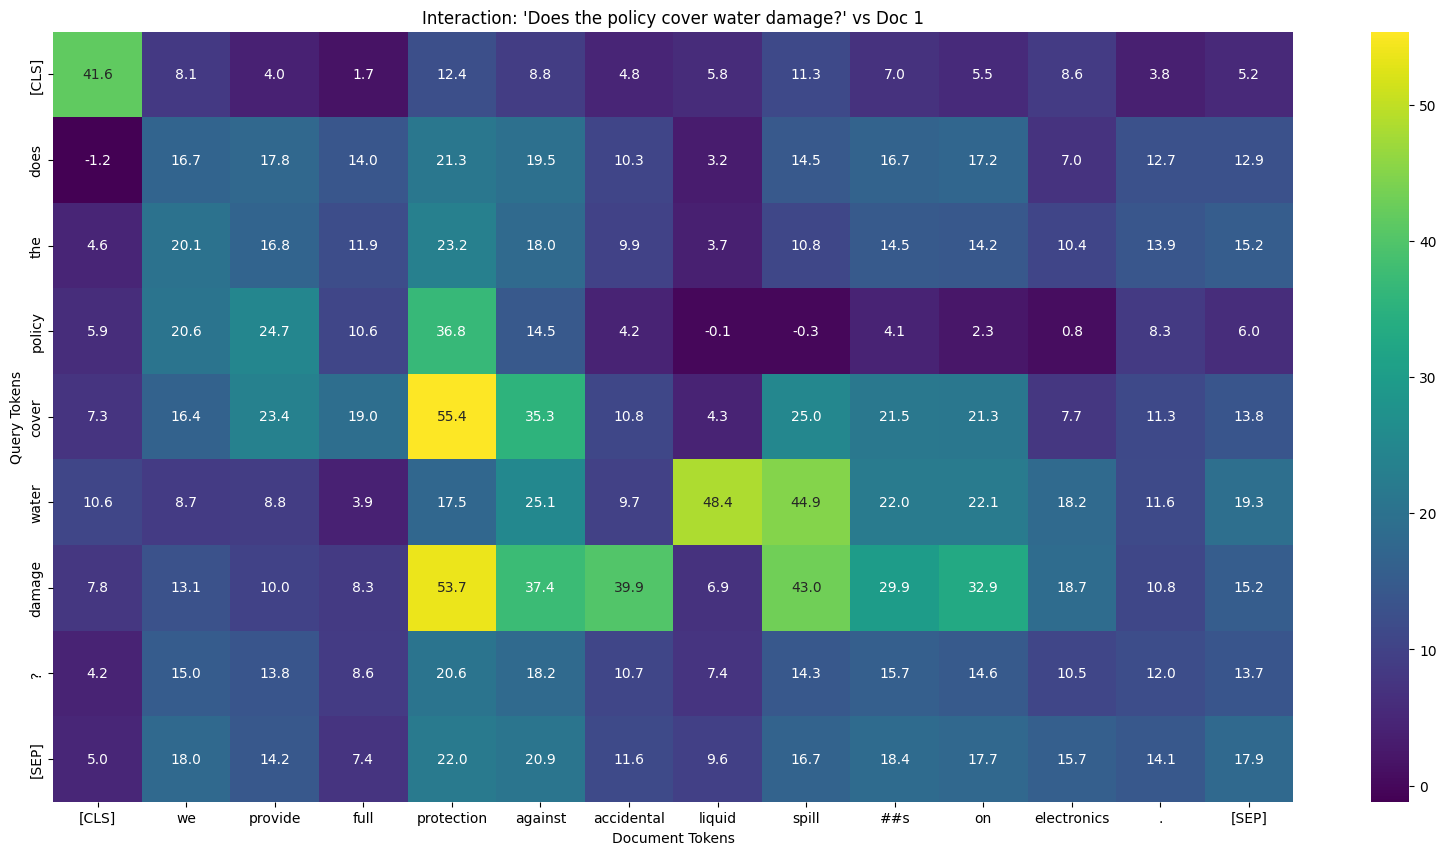

In [6]:

# 1. Get Query Tokens
q_tokens, q_vecs = get_token_embeddings(query)

# 2. Get Doc Tokens (Doc 1: Liquid Spills)
d_tokens, d_vecs = get_token_embeddings(documents[1]) 

# 3. Calculate Interaction (Dot Product)
# Matrix shape: (Query Tokens x Doc Tokens)
sim_matrix = q_vecs @ d_vecs.T 

print(f"🧮 Matrix Shape: {sim_matrix.shape}")

# 4. Plot Heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(sim_matrix, xticklabels=d_tokens, yticklabels=q_tokens, cmap="viridis", annot=True, fmt=".1f")
plt.title(f"Interaction: '{query}' vs Doc 1")
plt.xlabel("Document Tokens")
plt.ylabel("Query Tokens")
plt.show()


If we look at the matrix and find the row for **"water"** and the column for the **"liquid"** we can see that it has a relatively high score which demonstrates that the model understands semantic similarity at the word level.

## Step 6: Calculating MaxSim

The scoring formula is:
1. For each query token, find the **Maximum** similarity in the document.
2. **Sum** those maximums.

In [ ]:
def calc_maxsim(query_text, doc_text, verbose=False):
    q_tokens, q_vecs = get_token_embeddings(query_text)
    d_tokens, d_vecs = get_token_embeddings(doc_text)
    
    # 1. Interaction Matrix
    sim_matrix = q_vecs @ d_vecs.T 
    
    # 2. Max over Document tokens (Best match for each query token)
    max_scores = np.max(sim_matrix, axis=1)
    
    if verbose:
        print(f"\n📝 Inspecting: {doc_text[:40]}...")
        print("-" * 40)
        # Show which doc word matched each query word best
        best_match_indices = np.argmax(sim_matrix, axis=1)
        for i, q_tok in enumerate(q_tokens):
            best_doc_idx = best_match_indices[i]
            best_doc_tok = d_tokens[best_doc_idx]
            score = max_scores[i]
            
            # Print match logic (ignoring low score noise for clarity)
            if q_tok not in ['[CLS]', '[SEP]']:
                print(f"   Query: '{q_tok}' -> Best Doc Match: '{best_doc_tok}' (Score: {score:.3f})")

    # 3. Sum of maximums
    return np.sum(max_scores)

# Compare Doc 0 (Exclusion) vs Doc 1 (Liquid Spills)
score_d0 = calc_maxsim(query, documents[0], verbose=True)
score_d1 = calc_maxsim(query, documents[1], verbose=True)

print("\n" + "="*50)
print(f"🏆 Score Doc 0 (Exclusion): {score_d0:.4f}")
print(f"🏆 Score Doc 1 (Liquid):    {score_d1:.4f}")
print("="*50)


📝 Inspecting: Flood and water damage are strictly EXCL...
----------------------------------------
   Query: 'does' -> Best Doc Match: 'are' (Score: 36.811)
   Query: 'the' -> Best Doc Match: '[SEP]' (Score: 27.414)
   Query: 'policy' -> Best Doc Match: 'coverage' (Score: 46.764)
   Query: 'cover' -> Best Doc Match: 'coverage' (Score: 77.756)
   Query: 'water' -> Best Doc Match: 'flood' (Score: 67.360)
   Query: 'damage' -> Best Doc Match: 'damage' (Score: 105.672)
   Query: '?' -> Best Doc Match: '[SEP]' (Score: 25.886)

📝 Inspecting: We provide full protection against accid...
----------------------------------------
   Query: 'does' -> Best Doc Match: 'protection' (Score: 21.316)
   Query: 'the' -> Best Doc Match: 'protection' (Score: 23.172)
   Query: 'policy' -> Best Doc Match: 'protection' (Score: 36.763)
   Query: 'cover' -> Best Doc Match: 'protection' (Score: 55.367)
   Query: 'water' -> Best Doc Match: 'liquid' (Score: 48.354)
   Query: 'damage' -> Best Doc Match: 'protectio

## Step 7: Try Your Own Query

In [ ]:
def test_query(my_query):
    print(f"🔍 Testing Query: {my_query}")
    print("-" * 40)
    
    results = []
    for doc in documents:
        # Single Vector Score
        s_score = cosine_sim(model.encode(my_query), model.encode(doc))
        # Multi Vector Score
        m_score = calc_maxsim(my_query, doc, verbose=False)
        
        results.append({
            "Document": doc,
            "Single_Vector": s_score,
            "Multi_Vector": m_score
        })

    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values("Multi_Vector", ascending=False)
    
    display(df_results)

# Try it!
test_query("Is fire damage covered?")

🔍 Testing Query: Is fire damage covered?
----------------------------------------


,Document,Single_Vector,Multi_Vector
3,"Fire damage is covered up to $50,000.",0.729881,605.456177
0,Flood and water damage are strictly EXCLUDED f...,0.413977,361.468323
1,We provide full protection against accidental ...,0.334181,246.253555
2,Free water bottles are provided at the gym fac...,-0.020053,70.918823


## 🎓 Key Takeaways

### 1. The Trap of Single Vectors
With this, we look at the "vibe" of the sentence. For example:
- Doc 0 ("Water damage EXCLUDED") often ranks high because it shares the words "water" and "damage", even though the meaning is opposite.

### 2. The Power of Multi-Vector
In multi-vector, we look at the **Concept Matching**. For example:
- It matched **"water"** (Query) to **"liquid"** (Doc 1).
- It matched **"coverage"** (Query) to **"protection"** (Doc 1).
- Because it sums the best matches, it offers granular control.